<a href="https://colab.research.google.com/github/Whereamiactually/lyceumcompling11/blob/main/Spellchecking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исправление опечаток

(Спасибо Михаилу Нефёдову, автору материалов, и Татьяне Казаковой)

In [1]:
!pip install razdel tqdm

In [2]:
import os, re
from string import punctuation
import numpy as np
import json
from collections import Counter
from pprint import pprint
from nltk import sent_tokenize
punctuation += "«»—…“”"
punct = set(punctuation)
from sklearn.metrics import classification_report, accuracy_score
from string import punctuation
from razdel import sentenize
from razdel import tokenize as razdel_tokenize
import numpy as np
from collections import Counter

In [3]:
# библиотека для отслеживания прогресса
from tqdm.notebook import tqdm

Возьмем данные с соревнования [Dialog Evaluation 2016](http://www.dialog-21.ru/evaluation/2016/spelling_correction/) по исправлению опечаток. Данные представляют собой набор предложений (правильное - ошибочное). Задача найти слова с ошибками и заменить их на правильный вариант.

(Сейчас из данных удалены случаи, когда в словах пропущен или вставлен пробел, чтобы было проще сопоставить слова в предложении.)

In [4]:
! wget https://raw.githubusercontent.com/Whereamiactually/lyceumcompling11/main/Spellchecking/sents_with_mistakes.txt

--2023-10-13 11:05:19--  https://raw.githubusercontent.com/Whereamiactually/lyceumcompling11/main/Spellchecking/sents_with_mistakes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122030 (119K) [text/plain]
Saving to: ‘sents_with_mistakes.txt’

sents_with_mistakes 100%[===================>] 119.17K  --.-KB/s    in 0.003s  

2023-10-13 11:05:19 (41.6 MB/s) - ‘sents_with_mistakes.txt’ saved [122030/122030]



In [5]:
! wget https://raw.githubusercontent.com/Whereamiactually/lyceumcompling11/main/Spellchecking/correct_sents.txt

--2023-10-13 11:05:19--  https://raw.githubusercontent.com/Whereamiactually/lyceumcompling11/main/Spellchecking/correct_sents.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119546 (117K) [text/plain]
Saving to: ‘correct_sents.txt’

correct_sents.txt   100%[===================>] 116.74K  --.-KB/s    in 0.007s  

2023-10-13 11:05:19 (16.4 MB/s) - ‘correct_sents.txt’ saved [119546/119546]



In [6]:
! wget https://raw.githubusercontent.com/Whereamiactually/lyceumcompling11/main/Spellchecking/test_sample_testset.txt

--2023-10-13 11:05:19--  https://raw.githubusercontent.com/Whereamiactually/lyceumcompling11/main/Spellchecking/test_sample_testset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 325681 (318K) [text/plain]
Saving to: ‘test_sample_testset.txt’

test_sample_testset 100%[===================>] 318.05K  --.-KB/s    in 0.006s  

2023-10-13 11:05:20 (48.4 MB/s) - ‘test_sample_testset.txt’ saved [325681/325681]



In [7]:
! wget https://raw.githubusercontent.com/Whereamiactually/lyceumcompling11/main/Spellchecking/corr_sample_testset.txt

--2023-10-13 11:05:20--  https://raw.githubusercontent.com/Whereamiactually/lyceumcompling11/main/Spellchecking/corr_sample_testset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 326620 (319K) [text/plain]
Saving to: ‘corr_sample_testset.txt’

corr_sample_testset 100%[===================>] 318.96K  --.-KB/s    in 0.007s  

2023-10-13 11:05:20 (41.9 MB/s) - ‘corr_sample_testset.txt’ saved [326620/326620]



In [8]:
bad = open('sents_with_mistakes.txt', encoding = 'utf8').read().splitlines()
good = open('correct_sents.txt', encoding = 'utf8').read().splitlines()

In [9]:
len(good)

915

In [10]:
# Посмотрим на пары предложений
print(bad[12])
print(good[12])

хороше что на выходгых не было стен, только деревья да ручьи...
хорошо что на выходных не было стен только деревья да ручьи


In [13]:
# напишем функцию, которая будет сопоставлять слова в правильном и ошибочном варианте
# разобьем предложение по пробелам и удалим пунктуацию на границах слов
def align_words(sent_1, sent_2):
    tokens_1 = sent_1.lower().split()
    tokens_2 = sent_2.lower().split()

    tokens_1 = [token.strip(punctuation) for token in tokens_1]
    tokens_2 = [token.strip(punctuation) for token in tokens_2]

    tokens_1 = [token for token in tokens_1 if token]
    tokens_2 = [token for token in tokens_2 if token]

    assert len(tokens_1) == len(tokens_2)

    return list(zip(tokens_1, tokens_2))

In [14]:
pprint(align_words(good[1], bad[1]))

[('апофеозом', 'опофеозом'),
 ('дня', 'дня'),
 ('для', 'для'),
 ('меня', 'меня'),
 ('сегодня', 'сегодня'),
 ('стала', 'стала'),
 ('фраза', 'фраза'),
 ('услышанная', 'услышанная'),
 ('в', 'в'),
 ('новостях', 'новостях')]


Вытащим только неправильные варианты и заодно посчитаем процент ошибок.

In [15]:
mistakes = []
total = 0
for i in range(len(good)):
    word_pairs = align_words(good[i], bad[i])


    for pair in word_pairs:
        if pair[0] != pair[1]:
            mistakes.append(pair)
        total += 1

In [16]:
mistakes[:10]

[('симпатичнейшее', 'симпатичнейшое'),
 ('апофеозом', 'опофеозом'),
 ('поясним', 'пояним'),
 ('получатся', 'полчатся'),
 ('очень', 'оччччень'),
 ('насчет', 'нащщот'),
 ('отсутствие', 'отсуствие'),
 ('основная', 'основая'),
 ('напрасно', 'нарасно'),
 ('в', 'вобщем')]

In [17]:
print('Доля ошибок - ', len(mistakes) / total)

Доля ошибок -  0.12886443221610805


Обернем в Counter, чтобы сразу увидеть частотные ошибки.

In [18]:
Counter(mistakes).most_common(10)

[(('сегодня', 'седня'), 24),
 (('вообще', 'вобще'), 18),
 (('вообще', 'ваще'), 17),
 (('естественно', 'естесственно'), 17),
 (('хочется', 'хочеться'), 16),
 (('кстати', 'кстате'), 16),
 (('очень', 'ооочень'), 14),
 (('как-то', 'както'), 9),
 (('очень', 'оооочень'), 9),
 (('это', 'ето'), 9)]

Из-за того, что процент ошибок довольно низкий, не очень выгодно будет находить исправление для каждого слова. Нужен какой-то более простой классификатор, который выделит ошибочные слова, чтобы потом только их и редактировать.

Самый простой способ это сделать - составить словарь правильных слов и потом сравнивать с ним. Чтобы не делать этого вручную, можно взять какой-нибудь корпус текстов, прошедщих редактуру. Тексты из Википедии для этого хорошо подходят.

In [20]:
corpus = open('wiki_data.txt', encoding = 'utf8').read()

Попробуем предсказать ошибку простым заглядыванием в словарь. Если слово не в словаре - оно неправильное.

In [23]:
# создаем словарь
vocab = Counter(re.findall('\w+', corpus.lower()))

In [25]:
def predict_mistaken(word, vocab):
    return 0 if word in vocab else 1

In [27]:
# для оценки создаем два списка y_true и y_pred
# проходимся по предложениям
# сопоставляем слова с помощью функции align_words
# проходимся по парам слов и
# если слова одинаковые добавляем в y_true 0
# если слова разные добавляем в y_true 1
# предказываем ошибочность слова из bad списка
# добавляем предсказание в список y_pred

y_true = []
y_pred = []

for i in range(len(good)):
    word_pairs = align_words(good[i], bad[i])
    for pair in word_pairs:
        if pair[0] == pair[1]:
            y_true.append(0)
        else:
            y_true.append(1)

        y_pred.append(predict_mistaken(pair[1], vocab))


In [32]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [30]:
# оцените качество с помощью classification_report
print(metrics.classification_report(y_true, y_pred, ))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      8707
           1       0.59      0.88      0.71      1288

    accuracy                           0.91      9995
   macro avg       0.79      0.90      0.83      9995
weighted avg       0.93      0.91      0.91      9995



Confusion matrix:
[[7923  784]
 [ 149 1139]]


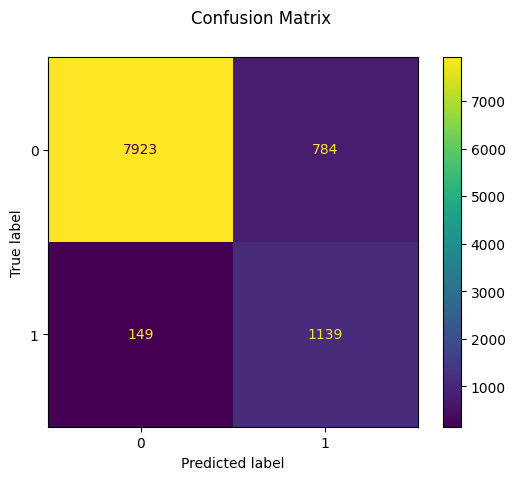

In [33]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

### Генерация исправлений

Теперь нужно думать о том, как исправить неправильные слова. Посмотрим, как это можно делать на примере известного **алгоритма Питера Норвига**. Идея алгоритма очень простая - для каждого неправильного слова нужно сгенерировать варианты исправлений и выбрать из них тот, что есть в словаре, а если таких несколько, то выбрать наиболее вероятный.

Неправильными считаются слова, которых нет в словаре (так же как в функции выше). А вероятность слова расчитывается по формуле - абсолютная частота слова в корпусе разделить на количество слов в корпусе.

Абсолютные частоты лежат в счетчике по текстам из Википедии.

In [ ]:
vocab.most_common(10)

[('в', 267296),
 ('и', 147115),
 ('на', 81926),
 ('с', 61681),
 ('года', 43894),
 ('по', 37235),
 ('году', 32197),
 ('из', 29150),
 ('был', 23293),
 ('не', 23228)]

В вероятности они преобразуются вот такой функцией.

In [34]:
N = sum(vocab.values())

def P(word, N = N):
    return vocab[word] / N

In [36]:
word = input('Введите cлово, вероятность которого хотите посмотреть в словаре: ')
print(P(word)) # вероятность слова по нашему словарю

Введите cлово, вероятность которого хотите посмотреть в словаре: солнце
2.4440966240624417e-05


(Для того, чтобы вывести привычную десятичную дробь, можно воспользоваться строковым методом `.format` с указанием количества знаков после запятой.)

In [38]:
print('{0:.15f}'.format(P(word)))

0.000024440966241


Теперь самое интересное - способ генерации вариантов исправлений. Они генерируются с помощью: **удаления, перестановки, замены, вставки**.

1) **Удаление** - по очереди выбрасываем из слова 1 букву (слово - лово, сово, слво, слоо, слов);  
2) **Перестановка** - по очереди меняем соседние буквы (слово - лсово, солво, слвоо, слоов);  
3) **Замена** - по очереди заменям каждую букву на другую букву алфавита (слово - алово, блово, влово, глово...);  
4) **Вставка** - по очереди вставляем между соседними буквами букву алфавита (слово - салово, сблово, свлово, сглово...).  

В алгоритме два уровня генерации - сначала генерируются варианты для оригинального слова, а потом варианты для каждого варианта. Таким образом, максимальное допустимое отличие для ошибки и предсказания - 2 буквы.

Оригинальный код [тут](https://norvig.com/spell-correct.html).

In [61]:
def correction(word):
    "Находим наиболее вероятное похожее слово"
    return max(candidates(word), key = P)

def candidates(word):
    "Генерируем кандидатов на исправление"
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words):
    "Выбираем слова, которые есть в корпусе"
    return set(w for w in words if w in vocab)

def edits1(word):
    "Создаем кандидатов, которые отличаются на одну букву"
    letters    = 'йцукенгшщзхъфывапролджэячсмитьбюё'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    #print(splits, deletes, transposes, replaces, inserts, sep = '\n')
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    "Создаем кандидатов, которые отличаются на две буквы"
    #print(e2 for e1 in edits1(word) for e2 in edits1(e1))
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

Попробуем исправить.

In [58]:
word = input('Введите cлово, которое хотите исправить: ')

Введите cлово, которое хотите исправить: яблако


In [59]:
%%time
correction(word)

[('', 'яблако'), ('я', 'блако'), ('яб', 'лако'), ('ябл', 'ако'), ('ябла', 'ко'), ('яблак', 'о'), ('яблако', '')]
['блако', 'ялако', 'ябако', 'яблко', 'яблао', 'яблак']
['бялако', 'ялбако', 'ябалко', 'яблкао', 'яблаок']
['йблако', 'цблако', 'ублако', 'кблако', 'еблако', 'нблако', 'гблако', 'шблако', 'щблако', 'зблако', 'хблако', 'ъблако', 'фблако', 'ыблако', 'вблако', 'аблако', 'пблако', 'рблако', 'облако', 'лблако', 'дблако', 'жблако', 'эблако', 'яблако', 'чблако', 'сблако', 'мблако', 'иблако', 'тблако', 'ьблако', 'бблако', 'юблако', 'ёблако', 'яйлако', 'яцлако', 'яулако', 'яклако', 'яелако', 'янлако', 'яглако', 'яшлако', 'ящлако', 'язлако', 'яхлако', 'яълако', 'яфлако', 'яылако', 'явлако', 'яалако', 'яплако', 'ярлако', 'яолако', 'яллако', 'ядлако', 'яжлако', 'яэлако', 'яялако', 'ячлако', 'яслако', 'ямлако', 'яилако', 'ятлако', 'яьлако', 'яблако', 'яюлако', 'яёлако', 'ябйако', 'ябцако', 'ябуако', 'ябкако', 'ябеако', 'ябнако', 'ябгако', 'ябшако', 'ябщако', 'ябзако', 'ябхако', 'ябъако', 

'яблоко'

Выводов по единичным примерам не сделаешь, поэтому давайте запустим на всем нашем корпусе.

Для оценки будем использовать три метрики:  
1) процент правильных слов;  
2) процент исправленных ошибок;  
3) процент ошибочно исправленных правильных слов.

In [62]:
correct = 0
total = 0

total_mistaken = 0
mistaken_fixed = 0

total_correct = 0
correct_broken = 0

cashed = {}
for i in tqdm(range(len(good))):
    word_pairs = align_words(good[i], bad[i])
    for pair in word_pairs:
        # чтобы два раза не исправлять одно и тоже слово - закешируем его
        # перед тем как считать исправление, проверим, нет ли его в кеше

        predicted = cashed.get(pair[1], correction(pair[1]))
        cashed[pair[1]] = predicted


        if predicted == pair[0]:
            correct += 1
        total += 1

        if pair[0] == pair[1]:
            total_correct += 1
            if pair[0] !=  predicted:
                correct_broken += 1
        else:
            total_mistaken += 1
            if pair[0] == predicted:
                mistaken_fixed += 1


  0%|          | 0/915 [00:00<?, ?it/s]

Получается, что в целом не стало лучше. Хотя 50% опечаток исправляются корректно

In [63]:
print(correct/total)
print(mistaken_fixed/total_mistaken)
print(correct_broken/total_correct)

0.8706353176588294
0.5100931677018633
0.07603077983231882


Ещё проблема тут в том, что алгоритм медленно работает для длинных слов.

In [ ]:
word = input('Введите cлово, которое хотите исправить: ')

In [ ]:
%%time
correction(word)

CPU times: user 722 µs, sys: 0 ns, total: 722 µs
Wall time: 892 µs


'солнце'

Посмотрим, как исправляются самые частотные ошибки.

In [ ]:
[(wt[0], wt[1], correction(wt[1])) for wt, _ in Counter(mistakes).most_common(10)]

[('сегодня', 'седня', 'седая'),
 ('вообще', 'вобще', 'вообще'),
 ('вообще', 'ваще', 'чаще'),
 ('естественно', 'естесственно', 'естественно'),
 ('хочется', 'хочеться', 'хочется'),
 ('кстати', 'кстате', 'кстати'),
 ('очень', 'ооочень', 'очень'),
 ('как-то', 'както', 'факто'),
 ('очень', 'оооочень', 'сорочень'),
 ('это', 'ето', 'что')]

### Метрики близости слов.

Вместо того, чтобы генерировать все варианты, можно искать похожие слова в словаре. Для этого нужно задать метрику похожести. Для исправления опечаток часто используются расстояния редактирования.

Самое известное расстояние редактирования - **расстояние Левенштейна**. Тут мы не будет подробно разбирать алгоритм, можете почитать [тут](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9B%D0%B5%D0%B2%D0%B5%D0%BD%D1%88%D1%82%D0%B5%D0%B9%D0%BD%D0%B0), посмотреть более понятный разбор [тут](https://www.youtube.com/watch?v=MiqoA-yF-0M), а код на Python'e есть [тут](https://ru.wikibooks.org/wiki/%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%BE%D0%B2/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9B%D0%B5%D0%B2%D0%B5%D0%BD%D1%88%D1%82%D0%B5%D0%B9%D0%BD%D0%B0).
Про самого Левенштейна можно почитать вот [тут](https://nplus1.ru/material/2017/09/25/vladimir-levenshtein).

Основная идея - найти минимальное число исправлений, которое нужно сделать в слове А, чтобы получить слово Б. Причем допустимы только три вида исправлений - **удаление, вставка, замена**.

Ещё есть расстояние **Дамерау-Левенштейна** - почти то же самое, только разрешена ещё **операция перестановки**.

Есть библиотека **textdistance**, в которой реализованы многие методы нахождения расстояний.

In [64]:
!pip install textdistance

In [65]:
import textdistance

In [66]:
def get_closest_match_with_metric(text, lookup,topn=20, metric=textdistance.levenshtein):
    # Counter можно использовать и с не целыми числами
    similarities = Counter()

    for word in lookup:
        similarities[word] = metric.normalized_similarity(text, word)

    return similarities.most_common(topn)

In [ ]:
word = input('Введите cлово, которое хотите исправить: ')

In [67]:
%%time
get_closest_match_with_metric('опофеоз', vocab, 5, textdistance.damerau_levenshtein)

CPU times: user 30.9 s, sys: 98.8 ms, total: 31 s
Wall time: 34.2 s


[('апофеоз', 0.8571428571428572),
 ('апофеоза', 0.75),
 ('апофеозом', 0.6666666666666667),
 ('апофеты', 0.5714285714285714),
 ('опорной', 0.5714285714285714)]

Спойлер: не сильно лучше работает.

## Готовые инструменты

Есть несколько готовых опечаточников:  
1) Hunspell - https://pypi.org/project/hunspell/  
2) Jamspell - https://github.com/bakwc/JamSpell#python  
3) Яндекс.Спеллер - https://yandex.ru/dev/speller/

Если вам понадобится в серьезной задаче исправлять опечатки, то начните с них, а не с алгоритма Норвига.

Для Яндекс Спеллера есть питоновская библиотека, которая упрощает его использование. У него есть некоторые ограничения (10 к запросов в день), но для небольших проектов этого вполне достаточно.

In [69]:
!pip install pyaspeller

In [70]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()

In [ ]:
# Так можно исправить предложение целиком
fixed = speller.spelled('Нипрвильное приджлажение.')
fixed

'Неправильное предложение.'

In [ ]:
# А так проверить и исправить отдельное слово
from pyaspeller import Word
check = Word('приджлажение')
print(check.text, check.correct, check.spellsafe, check.variants)

/usr/local/lib/python3.10/dist-packages/pyaspeller/word.py:17: UserWarning: Class Word is deprecated. Use YandexSpeller().spelled(text) instead
  warnings.warn("Class Word is deprecated. Use YandexSpeller().spelled(text) instead")


приджлажение False предложение ['предложение', 'придлажение', 'приджложение']


In [71]:
fixed = speller.spelled("Я ничего не понимаю.")
fixed

'Я ничего не понимаю.'

И ещё один посмотрим.

In [ ]:
! pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=1716a03fed2e1e3ea9a457c2cc2b080e887a06e1f06023e32667ee8d0e030387
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [ ]:
from autocorrect import Speller

In [ ]:
spell = Speller(lang='en')

In [ ]:
spell("I'm not sleapy and tehre is no place I'm giong to.")

"I'm not sleepy and there is no place I'm going to."

In [ ]:
%timeit spell("I'm not sleapy and tehre is no place I'm giong to.")

521 µs ± 174 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
# Можно ускорить
spell = Speller(fast=True)

In [ ]:
%timeit spell("I'm not sleapy and tehre is no place I'm giong to.")

390 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


А для русского?

In [ ]:
spell = Speller(lang='ru')

In [ ]:
spell('Нипрвильное приджлажение.')

'Првильное приджлажение.'

Ну вот, было неправильное, стало правильное.

(в общем, используйте YandexSpeller для русского)